# Import

In [1]:
import os
import io
import re
import nltk
import gzip
import spacy
import string
import random
import secrets
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import plotly.io as pio
from sklearn import tree
from typing import Counter
import plotly.express as px
from fuzzywuzzy import fuzz
from joblib import dump, load
from bs4 import BeautifulSoup
import category_encoders as ce
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import plotly.graph_objects as go
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from textblob import TextBlob, Word
from scipy.cluster import hierarchy
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from scipy.spatial.distance import pdist, squareform
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from flask import Flask, request, render_template, session, url_for, redirect
from sklearn.preprocessing import (MaxAbsScaler, MinMaxScaler, Normalizer,
                                   PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder


c:\Users\romar\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Pandas

Créer une dataframe via le lien suivant : http://bit.ly/imdbratings

Répondre aux questions suivantes:
- Quelle est la durée moyenne des films ayant le star_rating médian le plus bas de tous les genres ?
- Quelle est la durée médiane des films policiers dont le contenu_rating est de R ?
- Quels sont les 5 acteurs qui apparaissent le plus souvent ? Dans quels genres de film jouent-ils le plus souvent ?
- Y a t'il une corrélation entre genre et le star_rating ? Démontrez le par un test statistique.
- Y a t'il une corrélation entre les 15 acteurs les plus souvent présent et le star-rating ? Démontré le par un test statistique.
- Transformez la colonne star_rating pour avoir un type int en arrondissant les données à l'entier le plus proche
- Le star_rating et la duration sont-ils normalement distribués ? Démontrez le par un test statistique.

### Chargement du dataset


In [299]:
df_original = pd.read_csv("imdb_1000.csv",  encoding="utf-8")
df = df_original.copy()
# Résumé des informations du dataframe
your_dataframe = df
print("#"+"#"*20)
print(f"====liste des colonnes numeriques====: \n{
      your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}\n")
print("#"+"#"*20)
print(f"====liste des colonnes non numeriques====: \n{
      your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} ")
print("#"+"#"*20)
print("#"+"-"*79)
print(f"\n====shape====: {your_dataframe.shape} \n====list columns==== :\n{
      your_dataframe.columns.tolist()} ")
print(f"====Noms des colonnes avec au moins une valeur NA==== : {
      your_dataframe.columns[your_dataframe.isna().any()].tolist()}")
print("#"+"#"*20)
print(f"====Nombre de lignes avec au moins une valeur NA==== : {
      your_dataframe.isna().any(axis=1).sum()}")
print("#"+"#"*20)
print(f"====Colonne avec des na==== :{your_dataframe.isna().sum()} \n")
print("#"+"#"*20)
print(f"\ndf ====head==== :\n{your_dataframe.head(2)} \n")
print("#"+"#"*20)
print(f"\ndf ====describe==== :\n{your_dataframe.describe()} \n")
print("#"+"-"*79)
print("valeurs uniques des colonnes:")
for col in your_dataframe.columns:
    print("#"+"#"*20)
    print(f"====colonne====: {col} \n====nb valeur uniques====:{
          your_dataframe[col].nunique()} ")
    if your_dataframe[col].nunique() < 15:
        print(r", ".join(
            f"'{item}'" for item in your_dataframe[col].unique().tolist()))
    else:
        unique_values = your_dataframe[col].unique()[:15]
        print("====15 premiers====: \n" +
              ", ".join(f"'{item}'" for item in unique_values))
print("#"+"-"*79)


#####################
====liste des colonnes numeriques====: 
['star_rating', 'duration']

#####################
====liste des colonnes non numeriques====: 
['title', 'content_rating', 'genre', 'actors_list'] 
#####################
#-------------------------------------------------------------------------------

====shape====: (979, 6) 
====list columns==== :
['star_rating', 'title', 'content_rating', 'genre', 'duration', 'actors_list'] 
====Noms des colonnes avec au moins une valeur NA==== : ['content_rating']
#####################
====Nombre de lignes avec au moins une valeur NA==== : 3
#####################
====Colonne avec des na==== :star_rating       0
title             0
content_rating    3
genre             0
duration          0
actors_list       0
dtype: int64 

#####################

df ====head==== :
   star_rating                     title content_rating  genre  duration  \
0          9.3  The Shawshank Redemption              R  Crime       142   
1          9.2           

### Quelle est la durée moyenne des films ayant le star_rating médian le plus bas de tous les genres ?


In [101]:
#  filtre les genres en fonction de la valeur mediane de leur notation
filtre_genre_star_rating_mediane = df.groupby('genre')['star_rating'].median().sort_values(ascending=True)
print(f"\n filtre les genres en fonction de la valeur mediane de leur notation:\n{ filtre_genre_star_rating_mediane} \n")
# extrait le genre ayant la valeur mediane la plus petite, On autrait aussi pu prendre la première valeur car le df est classé dans l'ordre croissant
minimum_filtre_genre_star_rating_mediane = filtre_genre_star_rating_mediane.idxmin()
print(f"\n genre ayant la valeur mediane la plus petitee:\n{ minimum_filtre_genre_star_rating_mediane} \n")
# Maintenant que l'on cconnait le genre ayant la valeur mediane des notation la plus faible on calcule la moyenne de la durée des films "thriller"
duree_moyenne_film_minimum_filtre_genre_star_rating_mediane = df[df['genre']
                                                                 == minimum_filtre_genre_star_rating_mediane]['duration'].mean()
print(f"\nLa durée moyenne des films ayant le star_rating médian le plus bas de tous les genres
      :\n{duree_moyenne_film_minimum_filtre_genre_star_rating_mediane} min dont le genre est '{minimum_filtre_genre_star_rating_mediane}'\n")



 filtre les genres en fonction de la valeur mediane de leur notation:
genre
Thriller     7.60
Fantasy      7.70
Horror       7.70
Action       7.80
Biography    7.80
Comedy       7.80
Crime        7.80
Family       7.85
Adventure    7.90
Animation    7.90
Drama        7.90
Sci-Fi       7.90
History      8.00
Film-Noir    8.10
Mystery      8.10
Western      8.30
Name: star_rating, dtype: float64 


 genre ayant la valeur mediane la plus petitee:
Thriller 


La durée moyenne des films ayant le star_rating médian le plus bas de tous les genres:
114.2 min dont le genre est 'Thriller'



### Quelle est la durée médiane des films policiers dont le contenu_rating est de R ?


In [102]:
#  On filtre les films policiers 'cirme'  ayant un 'content_rating" de R
filtre_film_policier_content_rating = df[(
    df['genre'] == 'Crime') & (df['content_rating'] == 'R')]
print(f"\nfiltre les films policiers 'cirme'  ayant un 'content_rating' de R :\n{
      filtre_film_policier_content_rating} \n")
# on prend la valeur méidane de la dureée 'duration'
durée_mediane = filtre_film_policier_content_rating['duration'].median()
print(f"\nDurée médiane des films policiers dont le contenu_rating est R :\n{
      durée_mediane} min \n")



filtre les films policiers 'cirme'  ayant un 'content_rating' de R :
     star_rating                     title content_rating  genre  duration  \
0            9.3  The Shawshank Redemption              R  Crime       142   
1            9.2             The Godfather              R  Crime       175   
2            9.1    The Godfather: Part II              R  Crime       200   
4            8.9              Pulp Fiction              R  Crime       154   
21           8.7               City of God              R  Crime       130   
..           ...                       ...            ...    ...       ...   
927          7.5                     Brick              R  Crime       110   
931          7.4              Mean Streets              R  Crime       112   
950          7.4                     Bound              R  Crime       108   
969          7.4       Law Abiding Citizen              R  Crime       109   
978          7.4               Wall Street              R  Crime       1

### Quels sont les 5 acteurs qui apparaissent le plus souvent ? Dans quels genres de film jouent-ils le plus souvent ?


In [200]:
# il faut extriare les acteurs de la liste actors_list et supprimer le u, les ' , les [] et splitter sur la virgule
liste_acteurs = df['actors_list'].apply(
    lambda x: x.strip("[]").replace('u', ''))
liste_acteurs = liste_acteurs.apply(lambda x: x.replace("'", "").split(", "))
liste_acteurs
# faire une colonne par nom d'acteur pour compter leur nom bre d'apparitions avec explode, noous avons aussi u probléme d'encodage qu'i lfaut traiter avec des caractéres comme \\xfc
explode_liste_acteurs = [acteur.encode("latin-1").decode("unicode_escape")
                         for ligne_acteurs in liste_acteurs for acteur in ligne_acteurs]
# liste_acteurs.split(", ")
explode_liste_acteurs
# On compte les 5 premiers nombre des valeurs uniques de la liste explode_liste_acteurs


def extract_liste_acteurs(liste_acteurs, nombre_acteurs):
    extract_liste_acteurs = Counter(liste_acteurs).most_common(nombre_acteurs)
    return extract_liste_acteurs


top_5_acteurs = extract_liste_acteurs(explode_liste_acteurs, 5)
print(f"\n top_5_acteurs:\n{top_5_acteurs} \n")


# faire le lien entre les acteurs et leur genre
genre_top5_acteurs = []
for acteur in top_5_acteurs:
    filtre_ligne = df['actors_list'].str.contains(acteur[0])
    genre = df[filtre_ligne]['genre'].mode()[0]
    genre_top5_acteurs.append((acteur[0], genre))

# top_5_actors_genres = {actor[0]: df[df['actors_list'].str.contains(actor[0])]['genre'].mode()[0] for actor in top_5_actors}
for i in genre_top5_acteurs:
    print(f"Acteur : {i[0]:->20}  Genre le plus courant :{"-"*10} {i[1]}")
# genre_top5_acteurs



 top_5_acteurs:
[('Robert De Niro', 18), ('Clint Eastwood', 14), ('Brad Pitt', 14), ('Tom Hanks', 14), ('Al Pacino', 13)] 

Acteur : ------Robert De Niro  Genre le plus courant :---------- Crime
Acteur : ------Clint Eastwood  Genre le plus courant :---------- Action
Acteur : -----------Brad Pitt  Genre le plus courant :---------- Drama
Acteur : -----------Tom Hanks  Genre le plus courant :---------- Animation
Acteur : -----------Al Pacino  Genre le plus courant :---------- Crime


In [293]:
def liste_categories_acteurs(extract_n_acteurs):
    # faire le lien entre les acteurs et leur genre
    liste_categories_acteurs = []
    for acteur in extract_n_acteurs:
        liste_items = []  # Réinitialiser liste_items pour chaque acteur
        for col in df.columns:
            if col in ('genre', 'star_rating'):
                # print(f"nom colonne:{col}  ")
                filtre_ligne = df['actors_list'].str.contains(acteur[0])
                mode = df[filtre_ligne][col].mode(dropna=True)
                if not mode.empty:
                    col_items = mode[0]
                else:
                    col_items = ""
                liste_items.append((col, col_items))
                # print(f"\nliste_items :{liste_items} ")
        liste_categories_acteurs.append((acteur[0], liste_items))
    return liste_categories_acteurs


### Y a t'il une corrélation entre genre et le star_rating ? Démontrez le par un test statistique.


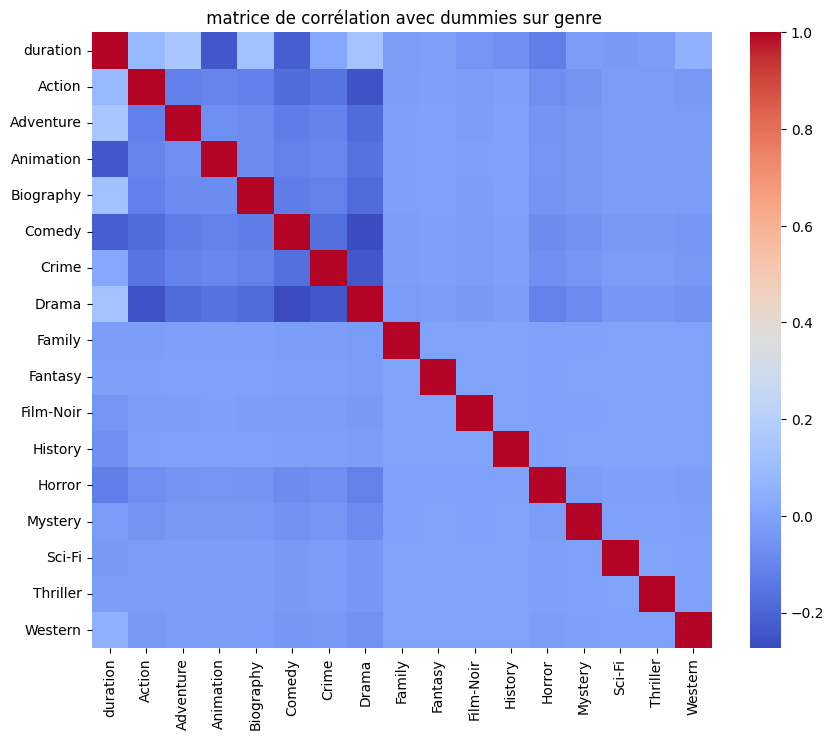

In [175]:
# listes colonnes
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

# convertion  colonne 'genre' en variables numériques
df_genre_dummies = pd.get_dummies(df['genre'])


# Concatenation des colonnes numériques avec les  colonnes converties avec dummies
df_numeric_dummies = pd.concat([df_numeric, df_genre_dummies], axis=1)

#  matrice de corrélation
corr_matrix_dummies = df_numeric_dummies.corr()

#  heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_dummies, cmap="coolwarm")
plt.title(" matrice de corrélation avec dummies sur genre")
plt.show()



res :
Chi2ContingencyResult(statistic=41.25750010106677, pvalue=0.08271574312626119, dof=30, expected_freq=array([[8.12665986e+01, 5.41777324e+01, 5.55669050e-01],
       [4.48161389e+01, 2.98774259e+01, 3.06435138e-01],
       [3.70480082e+01, 2.46986721e+01, 2.53319714e-01],
       [4.60112360e+01, 3.06741573e+01, 3.14606742e-01],
       [9.32175689e+01, 6.21450460e+01, 6.37385087e-01],
       [7.40960163e+01, 4.93973442e+01, 5.06639428e-01],
       [1.66118488e+02, 1.10745659e+02, 1.13585291e+00],
       [1.19509704e+00, 7.96731359e-01, 8.17160368e-03],
       [5.97548519e-01, 3.98365679e-01, 4.08580184e-03],
       [1.79264556e+00, 1.19509704e+00, 1.22574055e-02],
       [5.97548519e-01, 3.98365679e-01, 4.08580184e-03],
       [1.73289070e+01, 1.15526047e+01, 1.18488253e-01],
       [9.56077630e+00, 6.37385087e+00, 6.53728294e-02],
       [2.98774259e+00, 1.99182840e+00, 2.04290092e-02],
       [2.98774259e+00, 1.99182840e+00, 2.04290092e-02],
       [5.37793667e+00, 3.58529111e+0

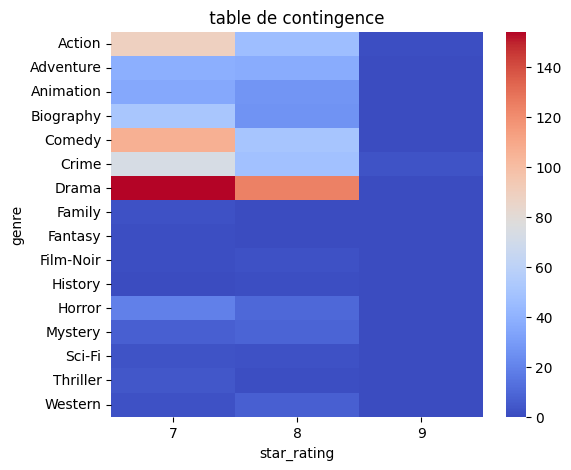

In [184]:
from scipy.stats import chi2_contingency
import numpy as np

# Créez une table de corrélation entre le genre et le star_rating
table_correlation = pd.crosstab(df['genre'], df['star_rating'])

# Calculez la statistique du Chi carré avec chi2_contingency
res = chi2_contingency(table_correlation)
print(f"\nres :\n{res} \n")
print(f"\nla correlation entre genre et star_rating est de p_value {
      res.pvalue:.2%} \n")

plt.figure(figsize=(6, 5))
sns.heatmap(table_correlation, cmap="coolwarm")
plt.title(" table de contingence ")
plt.show()


### Y a t'il une corrélation entre les 15 acteurs les plus souvent présent et le star-rating ? Démontré le par un test statistique.


In [300]:
top_15_acteurs = extract_liste_acteurs(explode_liste_acteurs, 18)
# print(f"\ntop_15_acteurs :\n{top_15_acteurs} \n")
top15_acteur_items = liste_categories_acteurs(top_15_acteurs)
print(top15_acteur_items)


[('Robert De Niro', [('star_rating', 7.8), ('genre', 'Crime')]), ('Clint Eastwood', [('star_rating', 7.5), ('genre', 'Action')]), ('Brad Pitt', [('star_rating', 7.5), ('genre', 'Drama')]), ('Tom Hanks', [('star_rating', 7.7), ('genre', 'Animation')]), ('Al Pacino', [('star_rating', 7.9), ('genre', 'Crime')]), ('Johnny Depp', [('star_rating', 7.8), ('genre', 'Drama')]), ('Christian Bale', [('star_rating', 7.6), ('genre', 'Action')]), ('Leonardo DiCaprio', [('star_rating', 7.5), ('genre', 'Biography')]), ('Dstin Hoffman', [('star_rating', ''), ('genre', '')]), ('Harrison Ford', [('star_rating', 7.5), ('genre', 'Action')]), ('James Stewart', [('star_rating', 8.1), ('genre', 'Drama')]), ('Jlianne Moore', [('star_rating', ''), ('genre', '')]), ('Denzel Washington', [('star_rating', 7.7), ('genre', 'Biography')]), ('Jack Nicholson', [('star_rating', 7.4), ('genre', 'Drama')]), ('Rssell Crowe', [('star_rating', ''), ('genre', '')]), ('Sean Connery', [('star_rating', 7.4), ('genre', 'Action')]


correlation_results :
[('Robert De Niro', 100.0, 0.0), ('Clint Eastwood', 100.0, 0.0), ('Brad Pitt', 100.0, 0.0), ('Tom Hanks', 100.0, 0.0), ('Al Pacino', 100.0, 0.0), ('Johnny Depp', 100.0, 0.0), ('Christian Bale', 100.0, 0.0), ('Leonardo DiCaprio', 100.0, 0.0), ('Harrison Ford', 100.0, 0.0), ('James Stewart', 100.0, 0.0), ('Denzel Washington', 100.0, 0.0), ('Jack Nicholson', 100.0, 0.0), ('Sean Connery', 100.0, 0.0), ('Ed Harris', 100.0, 0.0), ('Ethan Hawke', 100.0, 0.0)] 

acteur:------Robert De Niro : pvalue--------------------= 0.0% 

acteur:------Clint Eastwood : pvalue--------------------= 0.0% 

acteur:-----------Brad Pitt : pvalue--------------------= 0.0% 

acteur:-----------Tom Hanks : pvalue--------------------= 0.0% 

acteur:-----------Al Pacino : pvalue--------------------= 0.0% 

acteur:---------Johnny Depp : pvalue--------------------= 0.0% 

acteur:------Christian Bale : pvalue--------------------= 0.0% 

acteur:---Leonardo DiCaprio : pvalue--------------------= 0.0% 

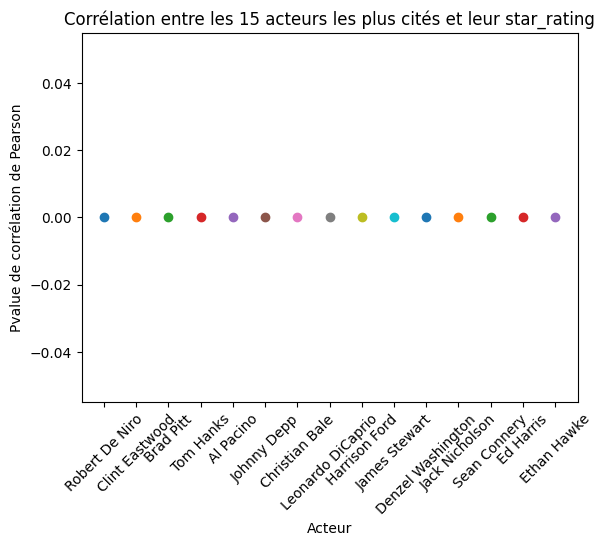

In [342]:
from scipy.stats import pearsonr
# top_15_actors = [actor[0] for actor in Counter(all_actors).most_common(15)]
top15_acteur_items

start_rating_par_acteur = [(acteur, attribut[1]) for acteur,
                           attributs in top15_acteur_items for attribut in attributs if attribut[0] == 'star_rating' and attribut[1]]
# print(f"\nstart_rating_par_acteur:\n{start_rating_par_acteur} \n")

# Calcul correlation
correlation_res = []
for actor, _ in start_rating_par_acteur:
    actor_ratings = df[df['actors_list'].str.contains(actor)]['star_rating']
    if len(actor_ratings) > 1:
        # corr, p_value = pearsonr(actor_ratings, actor_ratings)
        res = pearsonr(actor_ratings, actor_ratings)
        # correlation_results.append((actor, corr, p_value))
        correlation_res.append(
            (actor, round(res.statistic*100, 3), round(res.pvalue*100, 3)))
print(f"\ncorrelation_results :\n{correlation_res} \n")

# liste ety graphe
for acteur, stat, pvalue in correlation_res:
    print(f"acteur:{acteur:->20} : pvalue{"-"*20}= {pvalue}% \n")
    plt.scatter(acteur, pvalue)

plt.xlabel('Acteur')
plt.ylabel('Pvalue de corrélation de Pearson')
plt.title('Corrélation entre les 15 acteurs les plus cités et leur star_rating')
plt.xticks(rotation=45)
plt.show()


### Transformez la colonne star_rating pour avoir un type int en arrondissant les données à l'entier le plus proche


In [ ]:
# df['star_rating'] = df['star_rating'].astype(int)
df['star_rating_round'] = df['star_rating'].round().astype(int)
df['star_rating_round']


###  Test de normalite. Le star_rating et la duration sont-ils normalement distribués ? Démontrez le par un test statistique.

In [357]:
import scipy.stats as stats

# Test de normalité pour 'star_rating'
stat, p_value_star_rating = stats.shapiro(df['star_rating_round'])
print(f"Statistique de test pour 'star_rating_round' : {
      stat:.2%}, p-value : {p_value_star_rating:.2%}\n")

if p < 0.05:
    print(f"\nstar_rating-round avec  p_value :{
          p_value_star_rating} aussi faible les données ne sont pas distribuées normalement")
else:
    print(f"\nstar_rating-round avec  p_value :{
          p_value_star_rating}  les données ne sont pas distribuées normalement")

# Test de normalité pour 'duration'
stat_duration, p_value_duration = stats.shapiro(df['duration'])
print(f"\nStatistique de test pour 'duration' : {
      stat_duration:.2%}, p-value : {p_value_duration:.2%}\n")

if p < 0.05:
    print(f"\nduration avec  p_value :\n{
          p_value_duration} aussi faible les données ne sont pas distribuées normalement\n")
else:
    print(f"\nduration avec  p_value :\n{
          p_value_duration}  les données ne sont pas distribuées normalement\n")


Statistique de test pour 'star_rating_round' : 40.10%, p-value : 0.00%


star_rating-round avec  p_value :0.0 aussi faible les données ne sont pas distribuées normalement

Statistique de test pour 'duration' : 94.51%, p-value : 0.00%


duration avec  p_value :
1.341743098445088e-18 aussi faible les données ne sont pas distribuées normalement



# Data visualisation

Créer 5 graphiques en utilisant ce dataset > [Pokemon dataset](https://drive.google.com/file/d/116tn0wRma8wpELBAGzgcsHYPC9uUcgti/view):
- Un camembert utilisant Matplotlib et une légende.
- Un graphique linéaire utilisant Matplotlib avec une légende
- Une heatmap utilisant Seaborn
- Un boxplot utilisant seaborn
- Un pairplot utilisant Seaborn

### Chargement Dataframe et controle

In [14]:
df = pd.read_csv('pokemon.csv', sep=',',
                 index_col=False, encoding="ISO-8859-1")
df.drop('#', axis=1, inplace=True)
df


,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


### camembert utilisant Matplotlib et une légende

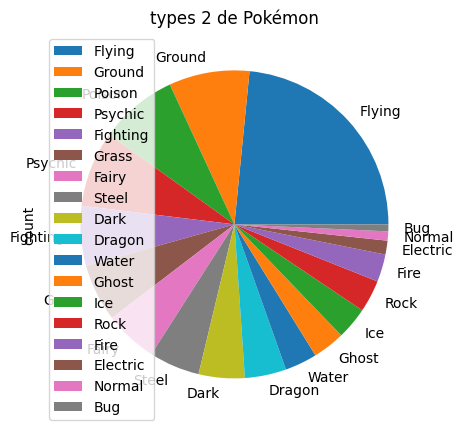

In [42]:
# figsize = (5, 5)
# fig = plot.pie(df, values='speed', names='type 1')
# fig = dtypes.value_counts().plot.pie()
# fig.show()
plt.figure(figsize=(10, 5))
df['Type 2'].value_counts().plot.pie()
plt.title('types 2 de Pokémon')
plt.legend()
plt.show()


### graphique linéaire utilisant Matplotlib avec une légende


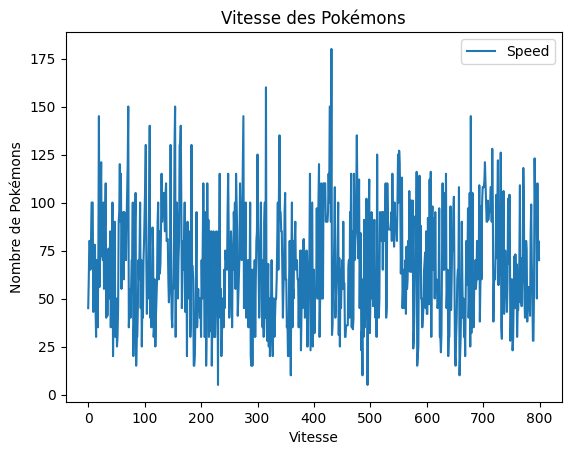

In [43]:
# ['Name', 'Type 1', 'Type 2', 'Legendary']
# ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
df['Speed'].plot()
# plt.figure(figsize=(6,6))
plt.title('Vitesse des Pokémons')
plt.xlabel('Vitesse')
plt.ylabel('Nombre de Pokémons')
plt.legend(['Speed'])
plt.show()


### heatmap utilisant Seaborn

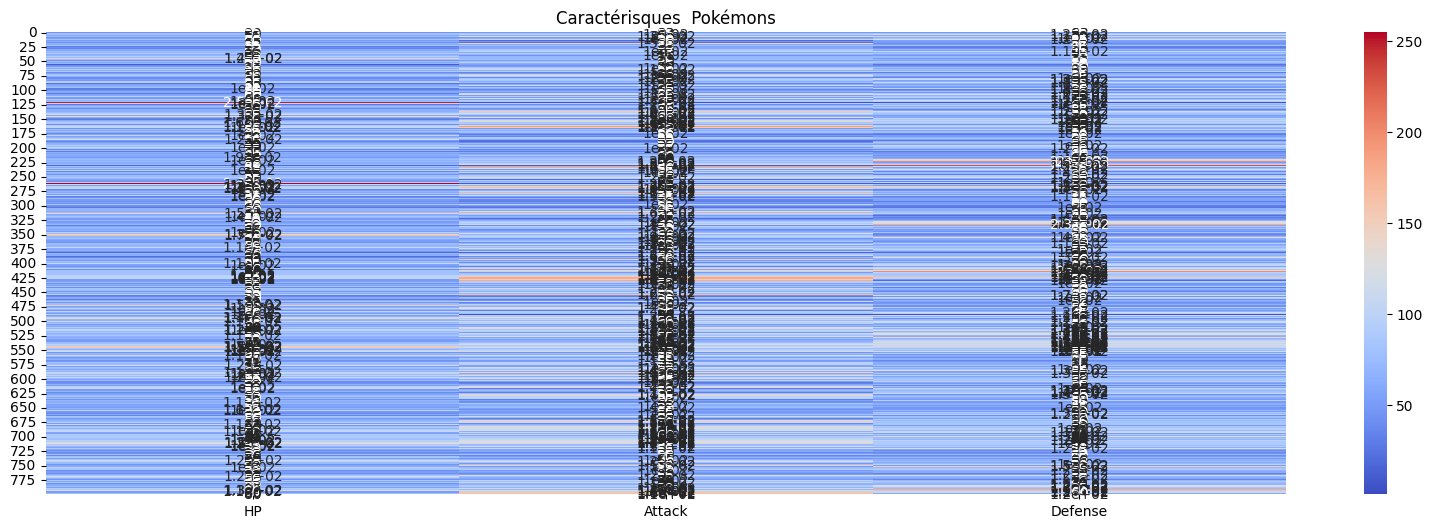

In [49]:
# ['Name', 'Type 1', 'Type 2', 'Legendary']
# ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
plt.figure(figsize=(20, 6))
sns.heatmap(df[['HP', 'Attack', 'Defense']], annot=True, cmap='coolwarm')
plt.title('Caractérisques  Pokémons')
plt.show()


### boxplot utilisant seaborn

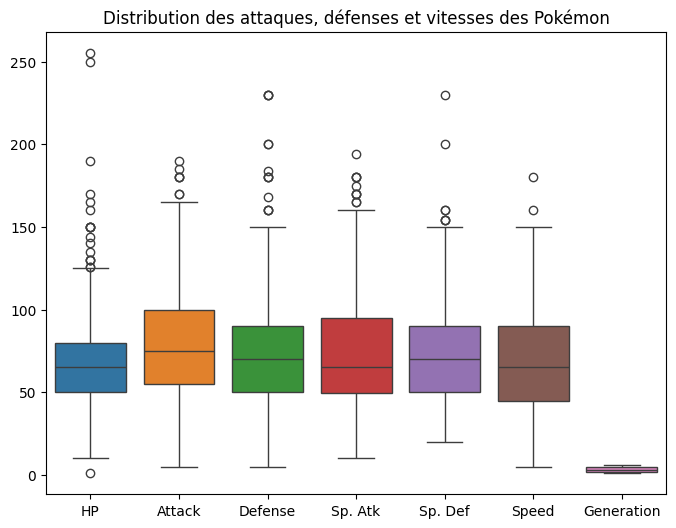

In [53]:
# ['Name', 'Type 1', 'Type 2', 'Legendary']
# ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['HP', 'Attack', 'Defense',
            'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']])
plt.title('Distribution des attaques, défenses et vitesses des Pokémon')
plt.show()


### pairplot utilisant Seaborn

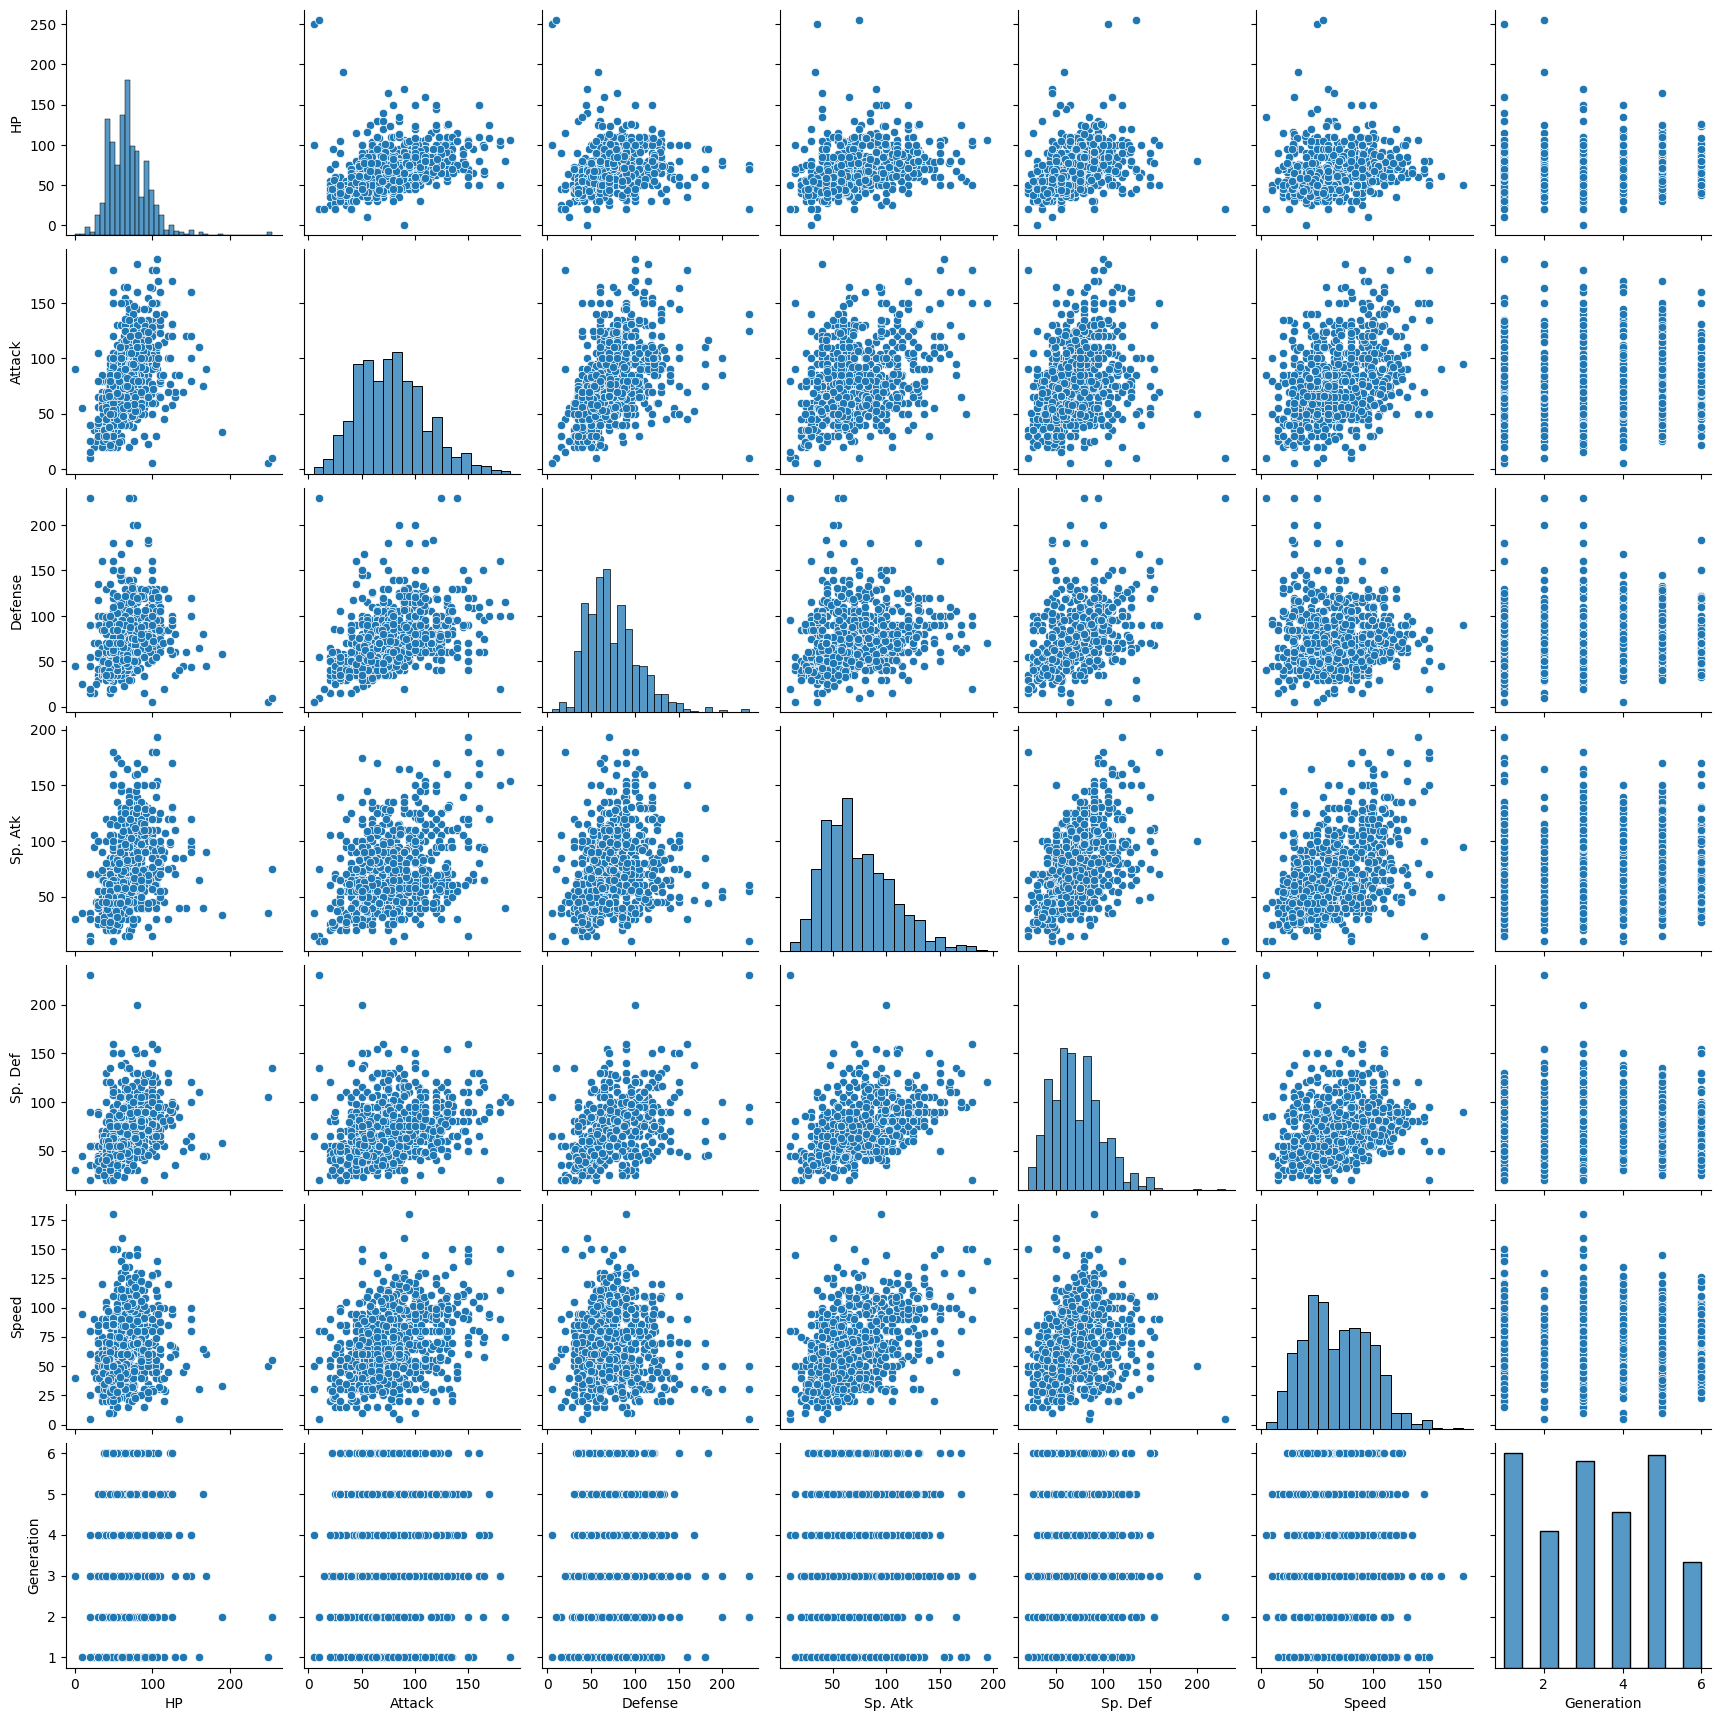

In [35]:
# ['Name', 'Type 1', 'Type 2', 'Legendary']
# ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
sns.pairplot(df[['HP', 'Attack', 'Defense', 'Sp. Atk',
             'Sp. Def', 'Speed', 'Generation']])
plt.show()


# Fonction IA

Créer une fonction prendra en paramètre un dataset, de choisir une ou plusieurs colonnes de features et une colonne de target, de choisir une tâche parmi **régression** (4 algorithmes différents), **classification** (4 algorithmes différents) et **clustering** (2 algorithmes différents), et enfin de faire une prédiction et d'observer les performances des modèles avec au moins 3 métriques. On pourra récupérer le modèle le plus performant ou tous les modèles. Il sera possible de les exporter via joblib ou pickle.

La fonction nous permettra également de faire de la réduction de dimension (1 algorithme) avant de lancer un modèle en indiquant un taux de variance expliqué précis, de reshape les données pour que l'entrainement fonctionne, et de connaitre les meilleurs hyperparamètres via grid search.

Il faut par contre que les données du dataset soient complètent et dans le bon type.

## Choix dataset


In [26]:
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
# crée la liste des datasets seaborn


def list_datasets_seaborn():
    datasets_seaborn = sns.get_dataset_names()
    return datasets_seaborn


# liste déroulante avec widget
liste_deroulante = widgets.Dropdown(
    options=list_datasets_seaborn(),
    description='Datasets      :',
)
display(liste_deroulante)

# Charger le dataset sélectionné


def charge_dataset(b):
    global df_original
    datasets_seaborn = list_datasets_seaborn()
    print(f"\n datasets_seaborn:\n{datasets_seaborn} \n")
    if liste_deroulante.value in datasets_seaborn:
        # Charger le dataset dans df
        df_original = sns.load_dataset(liste_deroulante.value)
        print(df_original.head())
    else:
        print("Le dataset demandé n'est pas disponible.")


# Bouton pour charger le dataset
bouton_chargment = widgets.Button(description="Charger le dataset")
bouton_chargment.on_click(charge_dataset)
display(bouton_chargment)
df_original


Dropdown(description='Datasets      :', options=('anagrams', 'anscombe', 'attention', 'brain_networks', 'car_c…

Button(description='Charger le dataset', style=ButtonStyle())

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367



 datasets_seaborn:
['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic'] 

   Unnamed: 0  id     diet  pulse    time  kind
0           0   1  low fat     85   1 min  rest
1           1   1  low fat     85  15 min  rest
2           2   1  low fat     88  30 min  rest
3           3   2  low fat     90   1 min  rest
4           4   2  low fat     92  15 min  rest

 datasets_seaborn:
['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic'] 

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5  

In [38]:
df = df_original.copy()
df


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## Analyse du dataset et classification automatique

In [43]:
import pandas as pd
import numpy as np


def determine_dataset_type(dataset):
    # Vérifie si le dataset est un DataFrame pandas (données structurées)
    if isinstance(dataset, pd.DataFrame):
        # Vérifie la présence de colonnes temporelles
        if any(pd.api.types.is_datetime64_any_dtype(dataset[col]) for col in dataset.columns):
            return "Time Series (Temporal Data)"
        # Vérifie la présence de colonnes spatiales (latitude/longitude)
        if 'latitude' in dataset.columns and 'longitude' in dataset.columns:
            return "Spatial Data"
        return "Structured Data"

    # Vérifie si le dataset est une série de textes ou de fichiers (données non structurées)
    if isinstance(dataset, (list, pd.Series)) and all(isinstance(x, str) for x in dataset):
        return "Unstructured Data (Text or Files)"

    # Vérifie si le dataset est sous forme de dictionnaires ou de JSON (semi-structuré)
    if isinstance(dataset, (dict, list)) and all(isinstance(x, (dict, list)) for x in dataset):
        return "Semi-Structured Data (e.g., JSON)"

    return "Unknown Type"


type_dataset = determine_dataset_type(df)

print(f"\ntype du dataset :\n{type_dataset} \n")



type du dataset :
Structured Data 



In [39]:
# Résumé des informations du dataframe
your_dataframe = df
print("#"+"-"*79)
print(f"\n====shape====: {your_dataframe.shape} \n====list columns==== :\n{
      your_dataframe.columns.tolist()} ")
print("#"+"#"*20)
print(f"====liste des colonnes numeriques====: \n{
      your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}\n")
print("#"+"#"*20)
print(f"====liste des colonnes non numeriques====: \n{
      your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} ")
print("#"+"#"*20)
print("valeurs uniques des colonnes:")
for col in your_dataframe.columns:
    print("#"+"#"*20)
    print(f"====colonne====: {col} \n====nb valeur uniques====:{
          your_dataframe[col].nunique()} ")
    if your_dataframe[col].nunique() < 15:
        print(r", ".join(
            f"'{item}'" for item in your_dataframe[col].unique().tolist()))
    else:
        unique_values = your_dataframe[col].unique()[:15]
        print("====15 premiers====: \n" +
              ", ".join(f"'{item}'" for item in unique_values))
print("#"+"-"*79)
print(f"====Noms des colonnes avec au moins une valeur NA==== : {
      your_dataframe.columns[your_dataframe.isna().any()].tolist()}")
print("#"+"#"*20)
print(f"====Nombre de lignes avec au moins une valeur NA==== : {
      your_dataframe.isna().any(axis=1).sum()}")
print("#"+"#"*20)
print(f"====Colonne avec des na==== :{your_dataframe.isna().sum()} \n")
print("#"+"#"*20)
print(f"\ndf ====head==== :\n{your_dataframe.head(2)} \n")
print("#"+"#"*20)
print(f"\ndf ====describe==== :\n{your_dataframe.describe()} \n")
print("#"+"-"*79)


#-------------------------------------------------------------------------------

====shape====: (344, 7) 
====list columns==== :
['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'] 
#####################
====liste des colonnes numeriques====: 
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

#####################
====liste des colonnes non numeriques====: 
['species', 'island', 'sex'] 
#####################
valeurs uniques des colonnes:
#####################
====colonne====: species 
====nb valeur uniques====:3 
'Adelie', 'Chinstrap', 'Gentoo'
#####################
====colonne====: island 
====nb valeur uniques====:3 
'Torgersen', 'Biscoe', 'Dream'
#####################
====colonne====: bill_length_mm 
====nb valeur uniques====:164 
====15 premiers====: 
'39.1', '39.5', '40.3', 'nan', '36.7', '39.3', '38.9', '39.2', '34.1', '42.0', '37.8', '41.1', '38.6', '34.6', '36.6'
#####################
====colonne====: bill_

## Preprocessing des datasets
### Preprocessing pour les Données structurées

In [47]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def preprocess_structured_data(dataset):
    # Séparer les colonnes numériques et catégorielles
    numeric_cols = dataset.select_dtypes(include=[np.number]).columns
    categorical_cols = dataset.select_dtypes(exclude=[np.number]).columns

    # Imputation
    num_imputer = SimpleImputer(strategy='mean')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    dataset[numeric_cols] = num_imputer.fit_transform(dataset[numeric_cols])
    dataset[categorical_cols] = cat_imputer.fit_transform(
        dataset[categorical_cols])

    # Normalisation pour les données numériques
    scaler = StandardScaler()
    dataset[numeric_cols] = pd.DataFrame(scaler.fit_transform(
        dataset[numeric_cols]), columns=numeric_cols)

    # Encodage One-Hot pour les données catégorielles
    encoder = OneHotEncoder()
    encoded_cat = encoder.fit_transform(dataset[categorical_cols]).toarray()
    encoded_cat_df = pd.DataFrame(
        encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

    # Concaténer les données numériques et catégorielles traitées
    dataset_preprocessed = pd.concat(
        [dataset[numeric_cols], encoded_cat_df], axis=1)

    return dataset_preprocessed


### Preprocessing pour les Données non structurées

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess_unstructured_data(dataset):
    # Prétraitement pour les données textuelles non structurées
    vectorizer = TfidfVectorizer(stop_words='english')
    dataset = vectorizer.fit_transform(dataset)
    return dataset


### Preprocessing pour les Données de type times series

In [33]:
def preprocess_temporal_data(dataset):
    # Prétraitement pour les données temporelles
    dataset.fillna(method='ffill', inplace=True)
    return dataset


### Preprocessing pour les Données Spatiales

In [34]:
from sklearn.preprocessing import MinMaxScaler


def preprocess_spatial_data(dataset):
    # Supposons que dataset est un DataFrame avec des colonnes 'latitude' et 'longitude'
    scaler = MinMaxScaler()
    dataset[['latitude', 'longitude']] = scaler.fit_transform(
        dataset[['latitude', 'longitude']])

    # Calcul d'une caractéristique dérivée, par exemple, la distance depuis le centre-ville
    city_center = (48.8566, 2.3522)  # Coordonnées de Paris, par exemple
    dataset['distance_from_center'] = np.sqrt(
        (dataset['latitude'] - city_center[0])**2 + (dataset['longitude'] - city_center[1])**2)

    return dataset


# Exemple d'utilisation
spatial_data = pd.DataFrame({
    'latitude': np.random.uniform(48.8, 48.9, 100),
    'longitude': np.random.uniform(2.3, 2.4, 100)
})
preprocessed_spatial_data = preprocess_spatial_data(spatial_data)


### preprocessing pour les Données Semi-Structurées (JSON)

In [35]:
import json
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def preprocess_json_data(json_data):
    # Convertir le JSON en DataFrame
    dataset = pd.json_normalize(json_data)

    # Gérer les valeurs manquantes
    imputer = SimpleImputer(strategy='most_frequent')
    dataset = pd.DataFrame(imputer.fit_transform(
        dataset), columns=dataset.columns)

    # Encoder les variables catégorielles
    encoder = OneHotEncoder()
    encoded_columns = encoder.fit_transform(dataset[['interests']]).toarray()
    dataset = dataset.join(pd.DataFrame(
        encoded_columns, columns=encoder.get_feature_names_out(['interests'])))

    return dataset


# Exemple d'utilisation
json_data = [
    {"name": "Alice", "age": 30, "interests": "music"},
    {"name": "Bob", "age": 25, "interests": "sports"},
    # ... autres données
]
preprocessed_json_data = preprocess_json_data(json_data)


### Fonction globale de preprocessing

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime


def preprocess_dataset(dataset):
    dataset_type = determine_dataset_type(dataset)

    if dataset_type == "Structured Data":
        dataset_preprocessed = preprocess_structured_data(dataset)
        return dataset_preprocessed

    elif dataset_type == "Unstructured Data (Text or Files)":
        dataset_preprocessed = preprocess_unstructured_data(dataset)
        return dataset_preprocessed

    elif dataset_type == "Time Series (Temporal Data)":
        dataset_preprocessed = preprocess_temporal_data(dataset)
        return dataset_preprocessed

    elif dataset_type == "Spatial Data":
        dataset_preprocessed = preprocess_spatial_data(dataset)
        return dataset_preprocessed

    elif dataset_type == "Semi-Structured Data (e.g., JSON)":
        dataset_preprocessed = preprocess_json_data(dataset)
        return dataset_preprocessed

    else:
        raise ValueError(
            "Type de dataset non reconnu ou non pris en charge pour le prétraitement")

    return dataset_preprocessed


In [49]:
df_pre = preprocess_dataset(df)
df_pre


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,-8.870812e-01,7.877425e-01,-1.422488,-0.565789,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-8.134940e-01,1.265563e-01,-1.065352,-0.503168,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-6.663195e-01,4.317192e-01,-0.422507,-1.192003,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-1.307172e-15,1.806927e-15,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-1.328605e+00,1.092905e+00,-0.565361,-0.941517,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
339,-1.307172e-15,1.806927e-15,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
340,5.294731e-01,-1.450118e+00,1.006038,0.811880,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
341,1.191758e+00,-7.380718e-01,1.506028,1.939064,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
342,2.351241e-01,-1.195816e+00,0.791756,1.250229,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## Fonctions Machine learning

In [3]:
['regression',
 'classification',
 'clustering']


['regression', 'classification', 'clustering']

In [72]:
import joblib
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, silhouette_score


def entrainer_et_evaluer_modeles(donnees, colonnes_features, colonne_cible, tache, choix_modele):
    """
    Entrainer et évaluer des modèles de machine learning en fonction de la tâche et du choix du modèle.

    :param donnees: DataFrame - le dataset à utiliser
    :param colonnes_features: list - liste des noms de colonnes à utiliser comme features
    :param colonne_cible: str - nom de la colonne cible pour la prédiction
    :param tache: str - type de tâche ('regression', 'classification', 'clustering')
    :param choix_modele: str - choix du modèle
    :return: dict - dictionnaire contenant les résultats d'évaluation pour le modèle choisi
    """
    # Séparer les features et la cible
    X = donnees[colonnes_features]
    y = donnees[colonne_cible]


    # Division des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Sélectionner le modèle et les hyperparamètres en fonction de la tâche et du choix de modèle
    modele, parametres = selectionner_modele_et_hyperparametres(tache, choix_modele)

    # Création du pipeline avec ACP
    pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA()),
        ('clf', modele)
    ])

    if tache != 'clustering':
            grid_search = GridSearchCV(pipeline, parametres, cv=5)
            grid_search.fit(X_train, y_train)
            print(f"Meilleurs paramètres {"-"*50}: {grid_search.best_params_}")
            print(f"Meilleur score (train) {"-"*50}: {grid_search.best_score_:.2%}")
            meilleur_modele = grid_search.best_estimator_
            score_test = meilleur_modele.score(X_test, y_test)
            print(f"Score sur l'ensemble de test {"-"*50}: {score_test:.2%}")
            return grid_search.best_score_, grid_search.best_params_, meilleur_modele
    else:
       modele.fit(X_train)
       labels = modele.labels_ if hasattr(modele, 'labels_') else None

        # Vérifier que le nombre de clusters est approprié
       if labels is not None and len(set(labels)) > 1 and len(set(labels)) < len(X_train):
           score = silhouette_score(X_train, labels)
           print(f"Score de silhouette {"-"*50}: {score:.2%}")
       else:
           score = None
           print("Score de silhouette non calculable.")
       return score, None, modele


def selectionner_modele_et_hyperparametres(tache, choix_modele):
    modeles = {
        'regression': {
            'RegressionLineaire': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'SVR': SVR()
        },
        'classification': {
            'RegressionLogistique': LogisticRegression(),
            'KNN': KNeighborsClassifier(),
            'ArbreDecision': DecisionTreeClassifier(),
            'ForetAleatoire': RandomForestClassifier()
        },
        'clustering': {
            'KMeans': KMeans(),
            'DBSCAN': DBSCAN()
        }
    }

    hyperparametres = {
        'RegressionLineaire': {'pca__n_components': [2, 3, 4, 5]},
        'Ridge': {'pca__n_components': [2, 3, 4, 5], 'clf__alpha': [0.01, 0.1, 1, 10]},
        'Lasso': {'pca__n_components': [2, 3, 4, 5], 'clf__alpha': [0.01, 0.1, 1, 10]},
        'SVR': {'pca__n_components': [2, 3, 4, 5], 'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [0.01, 0.1, 1]},
        'RegressionLogistique': {'pca__n_components': [2, 3, 4, 5], 'clf__C': [0.1, 1, 10, 100], 'clf__max_iter': [1000]},
        'KNN': {'pca__n_components': [2, 3, 4, 5], 'clf__n_neighbors': [3, 5, 7, 9]},
        'ArbreDecision': {'pca__n_components': [2, 3, 4, 5], 'clf__max_depth': [None, 10, 20, 30]},
        'ForetAleatoire': {'pca__n_components': [2, 3, 4, 5], 'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20, 30]},
        'KMeans': {'pca__n_components': [2, 3, 4, 5], 'clf__n_clusters': [2, 3, 4, 5], 'clf__n_init': [10]},
        'DBSCAN': {'pca__n_components': [2, 3, 4, 5], 'clf__eps': [0.1, 0.2, 0.5], 'clf__min_samples': [5, 10, 15]}
    }

    if choix_modele in modeles[tache]:
        modele = modeles[tache][choix_modele]
        parametres = hyperparametres[choix_modele]
    else:
        raise ValueError(
            "Combinaison de tâche et de modèle non prise en charge")

    return modele, parametres


### Préparation dataset


In [17]:
import seaborn as sns
import pandas as pd
import numpy as np

# Résumé des informations du dataframe
# ====shape====: (344, 7)
# ====list columns==== :
# ['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
# #####################
# ====liste des colonnes numeriques====:
# ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# #####################
# ====liste des colonnes non numeriques====:
# ['species', 'island', 'sex']

# Chargement du dataset des pingouins
donnees_pingouins = sns.load_dataset('penguins')

# Nettoyage et prétraitement des données (suppression des valeurs NA et encodage des variables catégorielles)
donnees_pingouins.dropna(inplace=True)
donnees_pretraitees = pd.get_dummies(donnees_pingouins)

# Sélection des colonnes de features et de la colonne cible
colonnes_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
                     'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_Female', 'sex_Male']
colonne_cible = 'species_Adelie'


### Preparation input pour choix de l'affichage

ajout choix optionnel

In [36]:
def afficher_menu_et_choisir_modele(tache_choix=None, modele_choix=None):
    taches = {
        '1': 'regression',
        '2': 'classification',
        '3': 'clustering'
    }
    modeles_par_tache = {
        'regression': {
            '1': 'RegressionLineaire',
            '2': 'Ridge',
            '3': 'Lasso',
            '4': 'SVR'
        },
        'classification': {
            '1': 'RegressionLogistique',
            '2': 'KNN',
            '3': 'ArbreDecision',
            '4': 'ForetAleatoire'
        },
        'clustering': {
            '1': 'KMeans',
            '2': 'DBSCAN'
        }
    }

    if not tache_choix:
        print("Choisissez le type de tâche:")
        for k, v in taches.items():
            print(f"{k}. {v}")
        tache_choix = input("Entrez le numéro de la tâche: ")

    tache = taches.get(tache_choix)

    if tache:
        if not modele_choix:
            print(f"Choisissez un modèle pour {tache}:")
            for k, v in modeles_par_tache[tache].items():
                print(f"{k}. {v}")
            modele_choix = input("Entrez le numéro du modèle: ")

        modele = modeles_par_tache[tache].get(modele_choix)

        return tache, modele
    else:
        print("Choix de tâche non valide.")
        return None, None


In [1]:
from joblib import dump

# Fonction pour sauvegarder le modèle entraîné
def sauvegarder_modele(modele, chemin_fichier):
    """
    Sauvegarde le modèle entraîné dans le chemin spécifié.

    :param modele: modèle scikit-learn entraîné
    :param chemin_fichier: chemin vers le fichier où le modèle sera sauvegardé
    """
    dump(modele, chemin_fichier)
    print(f"Modèle sauvegardé à l'emplacement : {chemin_fichier}")


### Test via le menu input 


In [73]:
# Exécution du menu et de la fonction d'entraînement
tache_choisie, modele_choisi = afficher_menu_et_choisir_modele()
if modele_choisi:
    entrainer_et_evaluer_modeles(
        donnees_pretraitees, colonnes_features, colonne_cible, tache_choisie, modele_choisi)


Choisissez le type de tâche:
1. regression
2. classification
3. clustering
Choisissez un modèle pour regression:
1. RegressionLineaire
2. Ridge
3. Lasso
4. SVR
Meilleurs paramètres --------------------------------------------------: {'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 82.52%
Score sur l'ensemble de test --------------------------------------------------: 88.25%


### Teste de toutes les possibilités:

In [74]:
# Test de toutes les possibilités

meilleur_score = -np.inf
meilleure_combinaison = None
meilleurs_hyperparametres = None

for tache in ['1', '2', '3']:
    for modele in ['1', '2', '3', '4']:
        tache_choisie, modele_choisi = afficher_menu_et_choisir_modele(tache, modele)
        if modele_choisi:
            print(f"Test avec tâche {tache_choisie} et modèle {modele_choisi}")
            score, hyperparametres, _ = entrainer_et_evaluer_modeles(
                donnees_pretraitees, colonnes_features, colonne_cible, tache_choisie, modele_choisi)
            if score is not None and score > meilleur_score:
                meilleur_score = score
                meilleure_combinaison = (tache_choisie, modele_choisi)
                meilleurs_hyperparametres = hyperparametres

# Afficher la meilleure combinaison et les hyperparamètres correspondants
print(f"Meilleure combinaison: Tâche {meilleure_combinaison[0]}, Modèle {meilleure_combinaison[1]}")
print(f"Meilleurs hyperparamètres: {meilleurs_hyperparametres}")
print(f"Meilleur score: {meilleur_score}")



Test avec tâche regression et modèle RegressionLineaire
Meilleurs paramètres --------------------------------------------------: {'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 82.84%
Score sur l'ensemble de test --------------------------------------------------: 85.90%
Test avec tâche regression et modèle Ridge
Meilleurs paramètres --------------------------------------------------: {'clf__alpha': 1, 'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 83.14%
Score sur l'ensemble de test --------------------------------------------------: 87.23%
Test avec tâche regression et modèle Lasso
Meilleurs paramètres --------------------------------------------------: {'clf__alpha': 0.01, 'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 83.40%
Score sur l'ensemble de test --------------------------------------------------: 86.55%
Test avec tâche r

c:\Users\romar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [54]:
# Résumé des informations du dataframe
your_dataframe = df_pre
print("#"+"-"*79)
print(f"\n====shape====: {your_dataframe.shape} \n====list columns==== :\n{
      your_dataframe.columns.tolist()} ")
print("#"+"#"*20)
print(f"====liste des colonnes numeriques====: \n{
      your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}\n")
print("#"+"#"*20)
print(f"====liste des colonnes non numeriques====: \n{
      your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} ")
print("#"+"#"*20)
print(f"====Noms des colonnes avec au moins une valeur NA==== : {
      your_dataframe.columns[your_dataframe.isna().any()].tolist()}")
print("#"+"#"*20)
print(f"====Nombre de lignes avec au moins une valeur NA==== : {
      your_dataframe.isna().any(axis=1).sum()}")
print("valeurs uniques des colonnes:")
for col in your_dataframe.columns:
    print("#"+"#"*20)
    print(f"====colonne====: {col} \n====nb valeur uniques====:{
          your_dataframe[col].nunique()} ")
    if your_dataframe[col].nunique() < 15:
        print(r", ".join(
            f"'{item}'" for item in your_dataframe[col].unique().tolist()))
    else:
        unique_values = your_dataframe[col].unique()[:15]
        print("====15 premiers====: \n" +
              ", ".join(f"'{item}'" for item in unique_values))
print("#"+"-"*79)
print("#"+"#"*20)
print(f"====Colonne avec des na==== :{your_dataframe.isna().sum()} \n")
print("#"+"#"*20)
print(f"\ndf ====head==== :\n{your_dataframe.head(2)} \n")
print("#"+"#"*20)
print(f"\ndf ====describe==== :\n{your_dataframe.describe()} \n")
print("#"+"-"*79)


#-------------------------------------------------------------------------------

====shape====: (344, 12) 
====list columns==== :
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species_Adelie', 'species_Chinstrap', 'species_Gentoo', 'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_Female', 'sex_Male'] 
#####################
====liste des colonnes numeriques====: 
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species_Adelie', 'species_Chinstrap', 'species_Gentoo', 'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_Female', 'sex_Male']

#####################
====liste des colonnes non numeriques====: 
[] 
#####################
====Noms des colonnes avec au moins une valeur NA==== : []
#####################
====Nombre de lignes avec au moins une valeur NA==== : 0
valeurs uniques des colonnes:
#####################
====colonne====: bill_length_mm 
====nb valeur uniques====:165 
====15 premiers====: 
'-0.8870812256081303'

## Graphiques
### Exploration des Données


Histogrammes (pour bill_length_mm,

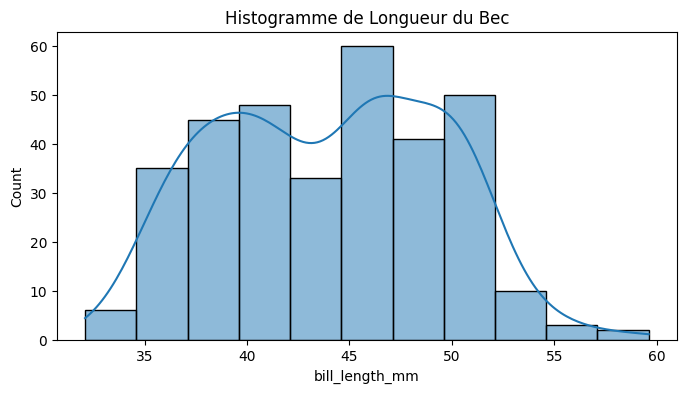

In [98]:
plt.figure(figsize=(8, 4))
sns.histplot(donnees_pingouins['bill_length_mm'], kde=True)
plt.title('Histogramme de Longueur du Bec')
plt.show()


Boxplots (pour bill_depth_mm,

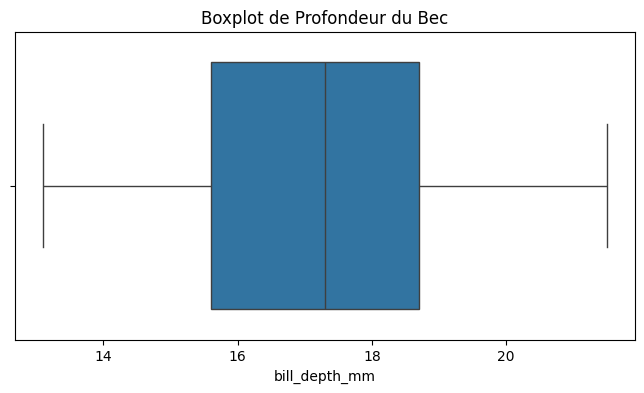

In [99]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=donnees_pingouins['bill_depth_mm'])
plt.title('Boxplot de Profondeur du Bec')
plt.show()


Graphes à Barres 

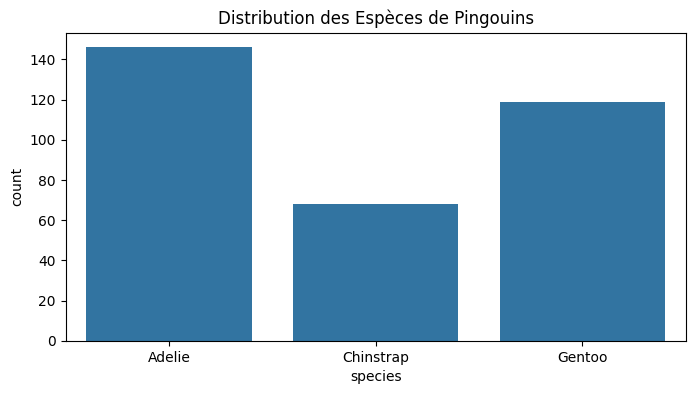

In [100]:
plt.figure(figsize=(8, 4))
sns.countplot(x=donnees_pingouins['species'])
plt.title('Distribution des Espèces de Pingouins')
plt.show()


Graphes de Dispersion (pour bill_length_mm et flipper_length_mm)

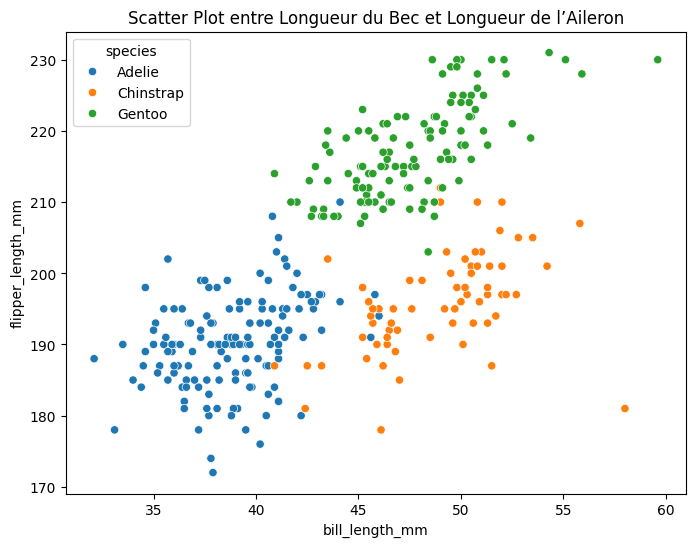

In [101]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bill_length_mm', y='flipper_length_mm', hue='species', data=donnees_pingouins)
plt.title('Scatter Plot entre Longueur du Bec et Longueur de l’Aileron')
plt.show()


### Évaluation des Modèles

In [ ]:
conf_mat = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de Confusion')
plt.ylabel('Vérité')
plt.xlabel('Prédiction')
plt.show()



### Résultats des Modèles de Clustering

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x='bill_length_mm', y='flipper_length_mm', hue=kmeans.labels_, data=donnees_pingouins)
plt.title('Clusters de Pingouins par KMeans')
plt.show()


###  Analyse en Composantes Principales (ACP)

Variance Expliquée par les Composantes (après l'ajustement de PCA sur les données)

In [77]:
import matplotlib.pyplot as plt

def plot_pca_variance(pca):
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.ylabel('Variance expliquée')
    plt.xlabel('Composantes principales')
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red',
             label="Cumul de la variance expliquée")
    plt.legend(loc='upper left')
    plt.show()


In [85]:
donnees_pingouins.select_dtypes('float64','int64')


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [86]:
donnees_pingouins.select_dtypes('object')


,species,island,sex
0,Adelie,Torgersen,Male
1,Adelie,Torgersen,Female
2,Adelie,Torgersen,Female
4,Adelie,Torgersen,Female
5,Adelie,Torgersen,Male
...,...,...,...
338,Gentoo,Biscoe,Female
340,Gentoo,Biscoe,Female
341,Gentoo,Biscoe,Male
342,Gentoo,Biscoe,Female


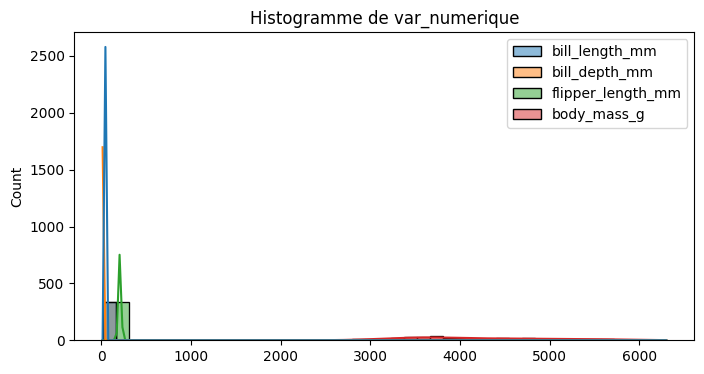

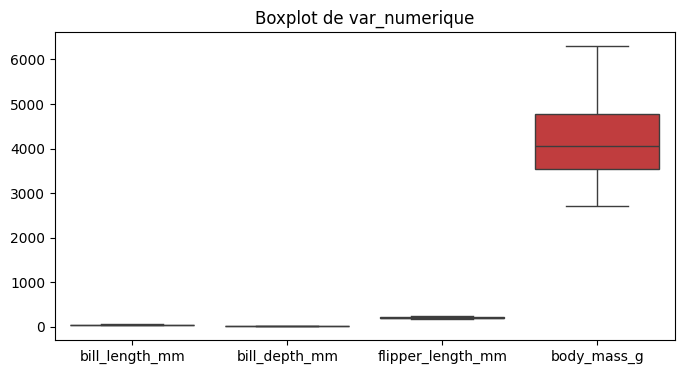

In [89]:
# Histogramme
plt.figure(figsize=(8, 4))
sns.histplot(donnees_pingouins.select_dtypes('float64','int64'), kde=True)
plt.title('Histogramme de var_numerique')
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(donnees_pingouins.select_dtypes('float64','int64'))
plt.title('Boxplot de var_numerique')
plt.show()


Graphes de Dispersion 

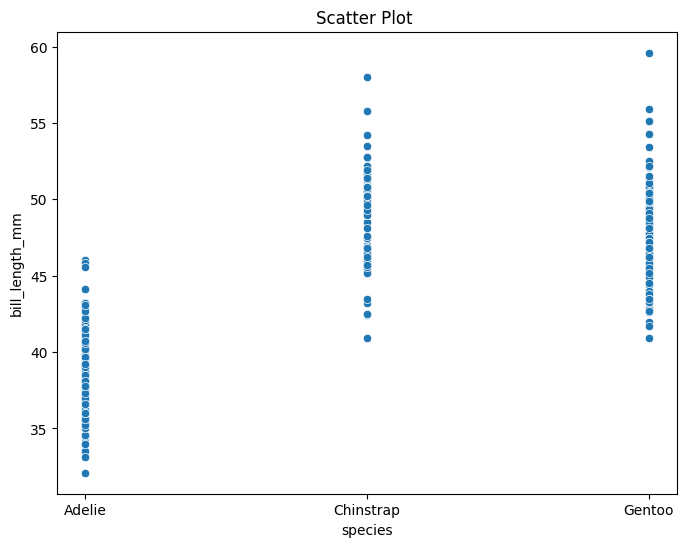

In [93]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='species', y='bill_length_mm', data=donnees_pingouins)
plt.title('Scatter Plot ')
plt.show()


Graphes de Corrélation

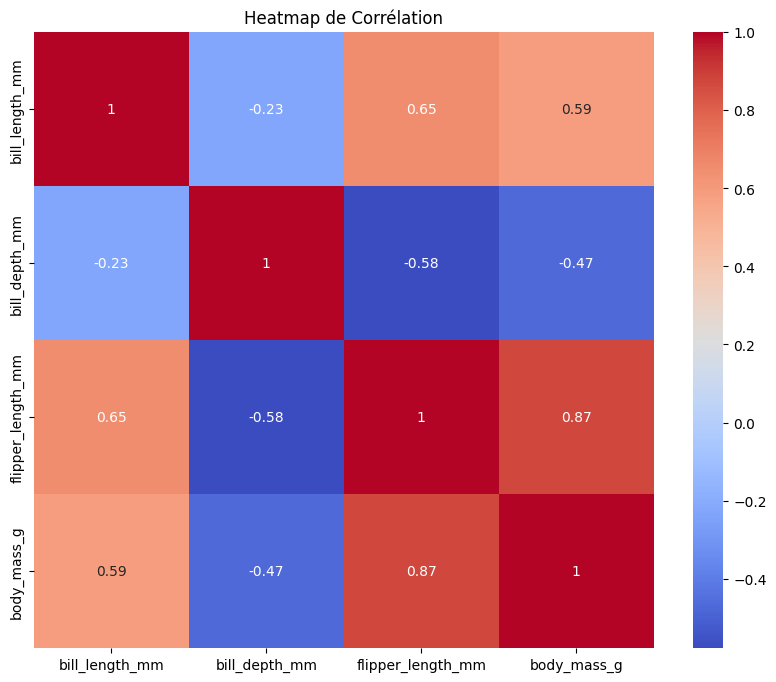

In [95]:
corr_matrix = donnees_pingouins.select_dtypes('float64','int64').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap de Corrélation')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, seuils = roc_curve(y_test, predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrais Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


## Fonction graphique globale

In [104]:
def generer_graphiques(donnees, X_train, y_train, modele, tache, choix_modele):
    # Sous-fonction pour afficher les histogrammes
    def afficher_histogrammes():
        for colonne in donnees.select_dtypes(include='number').columns:
            sns.histplot(donnees[colonne], kde=True)
            plt.title(f'Histogramme de {colonne}')
            plt.show()

    # Sous-fonction pour afficher les boxplots
    def afficher_boxplots():
        for colonne in donnees.select_dtypes(include='number').columns:
            sns.boxplot(x=donnees[colonne])
            plt.title(f'Boxplot de {colonne}')
            plt.show()

    # Sous-fonction pour afficher la variance expliquée par PCA (si PCA est utilisé)
    def afficher_variance_pca():
        if 'pca' in [step[0] for step in modele.steps]:
            pca = modele.named_steps['pca']
            plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
            plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
                     np.cumsum(pca.explained_variance_ratio_),
                     c='red',
                     label="Cumul de la variance expliquée")
            plt.xlabel('Composantes principales')
            plt.ylabel('Variance expliquée')
            plt.title('Variance Expliquée par les Composantes PCA')
            plt.legend(loc='upper left')
            plt.show()

    # Sous-fonction pour afficher les clusters (si un modèle de clustering est utilisé)
    def afficher_clusters():
        if tache == 'clustering':
            labels = modele.named_steps['clf'].labels_
            sns.scatterplot(x=X_train['bill_length_mm'], y=X_train['flipper_length_mm'], hue=labels)
            plt.title('Clusters des Pingouins')
            plt.show()

    # Appeler les sous-fonctions en fonction de la tâche et du modèle
    if tache in ['regression', 'classification']:
        afficher_histogrammes()
        afficher_boxplots()
        afficher_variance_pca()
    elif tache == 'clustering':
        afficher_clusters()


### Teste toutes les possiblités et sort les graphes

Test avec tâche regression et modèle RegressionLineaire
Meilleurs paramètres --------------------------------------------------: {'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 83.54%
Score sur l'ensemble de test --------------------------------------------------: 85.11%
Test avec tâche regression et modèle Ridge
Meilleurs paramètres --------------------------------------------------: {'clf__alpha': 0.01, 'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 84.36%
Score sur l'ensemble de test --------------------------------------------------: 83.13%
Test avec tâche regression et modèle Lasso
Meilleurs paramètres --------------------------------------------------: {'clf__alpha': 0.01, 'pca__n_components': 5}
Meilleur score (train) --------------------------------------------------: 83.58%
Score sur l'ensemble de test --------------------------------------------------: 87.34%
Test avec tâch

c:\Users\romar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


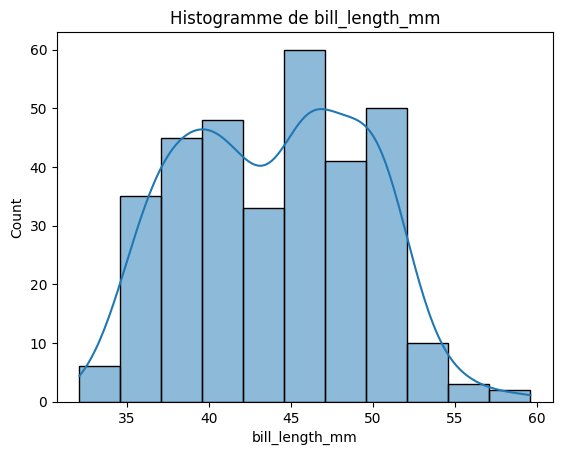

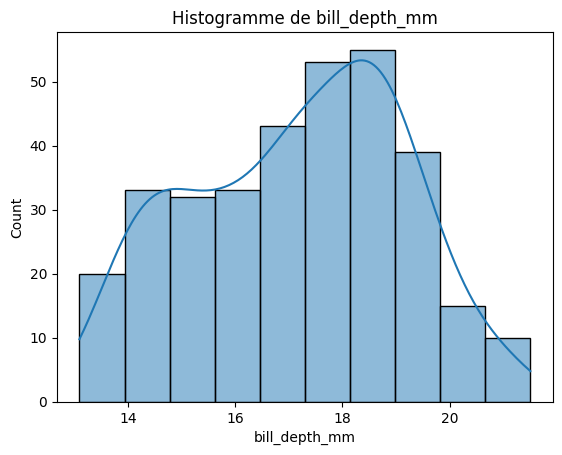

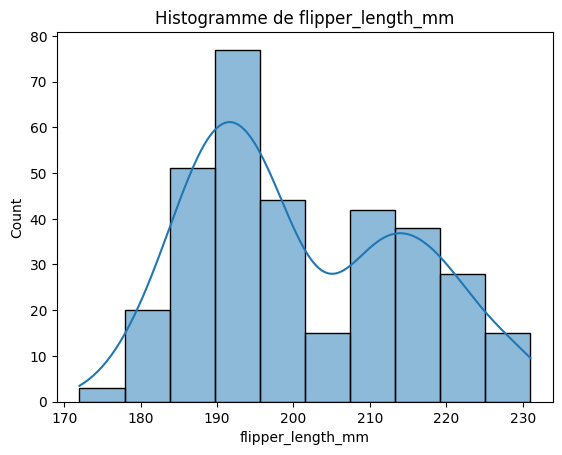

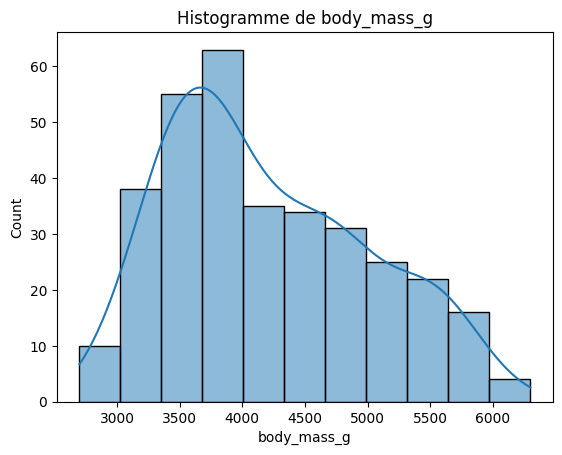

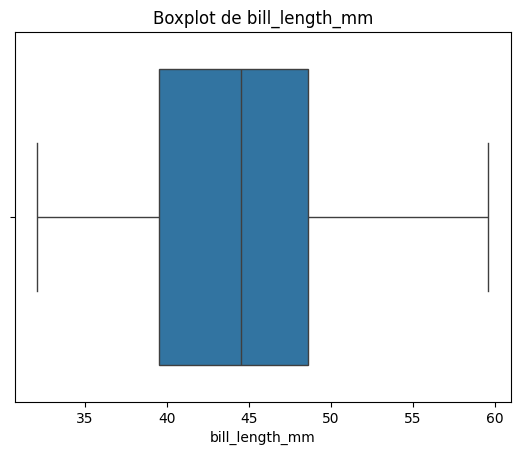

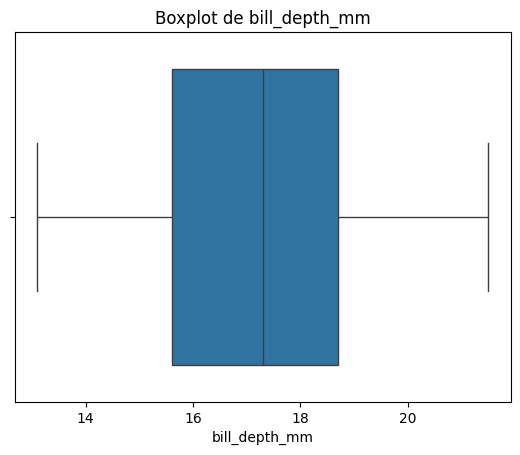

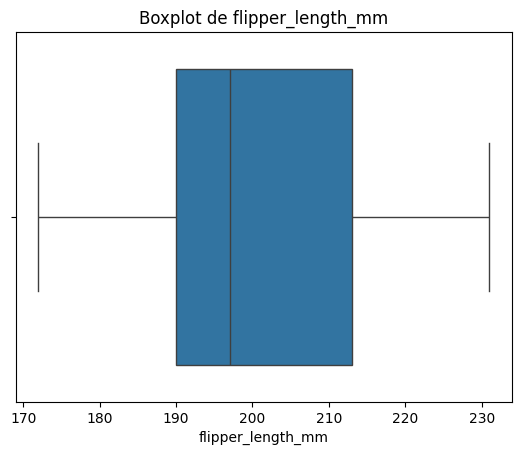

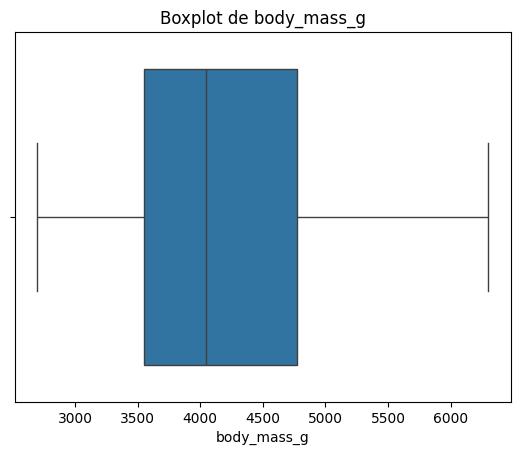

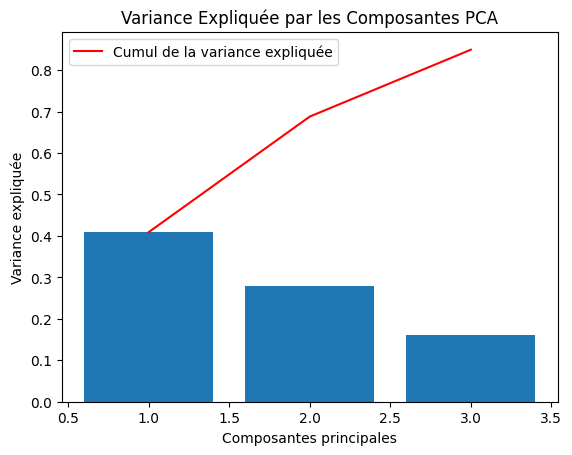

In [105]:
def tester_et_visualiser_modeles(donnees, colonnes_features, colonne_cible):
    meilleur_score = -np.inf
    meilleure_combinaison = None
    meilleurs_hyperparametres = None
    meilleur_modele = None
    X_train_meilleur = None
    y_train_meilleur = None

    for tache in ['1', '2', '3']:
        for modele in ['1', '2', '3', '4']:
            tache_choisie, modele_choisi = afficher_menu_et_choisir_modele(tache, modele)
            if modele_choisi:
                print(f"Test avec tâche {tache_choisie} et modèle {modele_choisi}")
                score, hyperparametres, modele_entraine = entrainer_et_evaluer_modeles(
                    donnees, colonnes_features, colonne_cible, tache_choisie, modele_choisi)
                if score is not None and score > meilleur_score:
                    meilleur_score = score
                    meilleure_combinaison = (tache_choisie, modele_choisi)
                    meilleurs_hyperparametres = hyperparametres
                    meilleur_modele = modele_entraine
                    X_train_meilleur, X_test, y_train_meilleur, y_test = train_test_split(donnees[colonnes_features], donnees[colonne_cible], test_size=0.2)

    # Affichage des résultats
    print(f"Meilleure combinaison: Tâche {meilleure_combinaison[0]}, Modèle {meilleure_combinaison[1]}")
    print(f"Meilleurs hyperparamètres: {meilleurs_hyperparametres}")
    print(f"Meilleur score: {meilleur_score}")

    # Générer des graphiques pour la meilleure combinaison
    if meilleur_modele:
        generer_graphiques(donnees, X_train_meilleur, y_train_meilleur, meilleur_modele, meilleure_combinaison[0], meilleure_combinaison[1])

# Appel de la fonction avec les données
tester_et_visualiser_modeles(donnees_pretraitees, colonnes_features, colonne_cible)


## Generalisation à n'importe quel dataset